# Notebook 5 — Pathway Enrichment Analysis

**Goal:** Convert differential expression (DE) results generated in Notebook 4 into pathway-level insights by running gene set enrichment analysis (GSEA) on a ranked list of all genes.

**Why GSEA?**
- Enrichment on a *ranked* gene list captures subtle but coordinated pathway shifts that may be missed when only looking at hard DE thresholds (Subramanian et al., 2005).
- Python tooling such as `gseapy` (wrapper around the Broad Institute GSEA implementation) and `blitzgsea` provide reproducible pipelines and direct access to MSigDB/Enrichr resources, which aligns with modern best practices for interpreting single-cell DE signatures.
- Ranking genes by a combination of log2 fold-change direction and p-value magnitude is a standard approach recommended in the GSEApy documentation and recent benchmarking work from the Ma’ayan Lab (blitzgsea, 2024), ensuring pathways with modest but consistent shifts are captured.


## Overview & references
1. **Assemble the ranked gene list** for every `(cell_type, contrast)` pair exported in `differential_expression_results.csv`. We follow the “signed –log10(p-value) × log2FC” metric suggested in recent `gseapy` tutorials so that both significance and direction contribute.
2. **Load curated gene set libraries** (Hallmark, KEGG, GO Biological Process) directly from Enrichr/MSigDB via `gseapy.get_library`. These collections were highlighted as high-signal options in the 2024 blitzgsea benchmark and remain common choices in scRNA-seq pathway workflows.
3. **Run `gseapy.prerank`** per group with 1,000 permutations, min/max gene-set sizes, and record normalized enrichment scores (NES), nominal p-values, FDR q-values, and leading-edge subsets.
4. **Persist outputs** under `cell_annotation_colab/outputs/pathway_enrichment/` with both the raw GSEApy result tables and an aggregated summary CSV.
5. **Plot top pathways** for quick QC and storytelling leverage.


## Imports & environment checks


In [8]:
from __future__ import annotations

from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from typing import Dict, Iterable, List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

import gseapy as gp


In [9]:
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")


## Configurable parameters


In [ ]:
PROJECT_ROOT = Path("/Users/melissadu/Documents/projects/tsai-lab-scrna").resolve()
DE_RESULTS_PATH = PROJECT_ROOT / "cell_annotation_colab/outputs/differential_expression_results/differential_expression_results.csv"
OUTPUT_DIR = PROJECT_ROOT / "cell_annotation_colab/outputs/pathway_enrichment"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Gene set libraries to pull from Enrichr/MSigDB via gseapy.
# NOTE: Many Enrichr collections already encode organism in the library name, so
# passing `organism=None` skips the extra filter that caused the KEGG error.
GENE_SET_COLLECTIONS = {
    "Hallmark": ("MSigDB_Hallmark_2020", None),
    "KEGG": ("KEGG_2021_Mouse", None),
    "GO_Biological_Process": ("GO_Biological_Process_2021", None),
    # TODO: Include
}

# Optional filters to focus the analysis.
CELL_TYPE_FILTER: Optional[Iterable[str]] = None  # e.g. ["Excit", "Inhib"]
CONTRAST_FILTER: Optional[Iterable[str]] = None  # e.g. ["E3_GENUS_vs_Ctrl"]

# GSEA parameters
MIN_GENE_SET_SIZE = 15
MAX_GENE_SET_SIZE = 500
N_PERMUTATIONS = 1000
THREADS = 4  # gseapy >=1.1 expects `threads` instead of `processes`
RANKING_EPS = np.finfo(float).eps


## Helper dataclasses & utilities


In [11]:
@dataclass
class RankingConfig:
    logfc_col: str = "logFC"
    pval_col: str = "P.Value"


def safe_negative_log10(values: pd.Series) -> pd.Series:
    """Numerically stable -log10 for p-values that may contain zeros."""
    clipped = values.clip(lower=RANKING_EPS)
    return -np.log10(clipped)


def compute_rank_vector(df: pd.DataFrame, config: RankingConfig = RankingConfig()) -> pd.Series:
    """Return a preranked Series indexed by gene symbol."""
    required_cols = ["gene", config.logfc_col, config.pval_col]
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    clean = df.dropna(subset=required_cols).copy()
    if clean.empty:
        return pd.Series(dtype=float)

    clean["rank_score"] = (
        clean[config.logfc_col] * safe_negative_log10(clean[config.pval_col])
    )

    # Deduplicate genes by retaining the entry with the largest absolute score.
    clean["abs_rank"] = clean["rank_score"].abs()
    clean = (
        clean.sort_values("abs_rank", ascending=False)
        .drop_duplicates(subset="gene", keep="first")
        .sort_values("rank_score", ascending=False)
    )
    ranking = clean.set_index("gene")["rank_score"]

    # Break ties deterministically so GSEA receives strictly monotonic ranks.
    if ranking.duplicated().any():
        tie_break = ranking.rank(method="first", ascending=False) * 1e-12
        ranking = ranking + tie_break

    return ranking


def load_gene_sets(collections: Dict[str, tuple]) -> Dict[str, Dict[str, List[str]]]:
    """Fetch gene set libraries using gseapy.get_library."""
    loaded_sets = {}
    for label, (library_name, organism) in collections.items():
        try:
            print(
                f"Loading {label} from {library_name}" + (f" ({organism})" if organism else "") + "..."
            )
            kwargs = {"name": library_name}
            if organism:
                kwargs["organism"] = organism
            gene_set = gp.get_library(**kwargs)
            loaded_sets[label] = gene_set
        except Exception as exc:  # pragma: no cover - informational
            print(f"⚠️  Failed to load {label}: {exc}")
    return loaded_sets


def load_de_results(
    path: Path,
    cell_types: Optional[Iterable[str]] = None,
    contrasts: Optional[Iterable[str]] = None,
) -> pd.DataFrame:
    """Load differential expression results and optionally filter them."""
    df = pd.read_csv(path)
    if cell_types is not None:
        df = df[df["cell_type"].isin(cell_types)]
    if contrasts is not None:
        df = df[df["contrast"].isin(contrasts)]
    return df


def label_for_group(cell_type: str, contrast: str) -> str:
    """Sanitized label for filesystem paths."""
    safe_cell = cell_type.replace(" ", "_")
    safe_contrast = contrast.replace(" ", "_")
    return f"{safe_cell}__{safe_contrast}"


def standardize_gsea_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Lowercase/slugify GSEApy columns and map vendor-specific names to canonical ones."""
    normalized = df.copy()
    normalized.columns = [
        col.strip().lower().replace(" ", "_").replace("-", "_") for col in normalized.columns
    ]

    column_aliases = {
        "nom_p_val": "pval",
        "nominal_p_value": "pval",
        "nominal_p_val": "pval",
        "p_value": "pval",
        "p_val": "pval",
        "fdr_q_val": "fdr",
        "fdr_q_value": "fdr",
        "fdr_q": "fdr",
        "fdr_qval": "fdr",
        "tag_%": "tag_percent",
        "gene_%": "gene_percent",
        "leading_edge": "lead_genes",
    }
    for source, target in column_aliases.items():
        if source in normalized.columns and target not in normalized.columns:
            normalized = normalized.rename(columns={source: target})

    return normalized


## Run preranked GSEA for each (cell type, contrast)


In [12]:
def run_prerank_for_group(
    ranking: pd.Series,
    gene_sets: Dict[str, Dict[str, List[str]]],
    cell_type: str,
    contrast: str,
) -> List[pd.DataFrame]:
    """Execute gseapy.prerank across all gene set collections for a single group."""
    group_label = label_for_group(cell_type, contrast)
    group_dir = OUTPUT_DIR / group_label
    group_results: List[pd.DataFrame] = []

    if ranking.empty:
        print(f"Skipping {group_label}: no genes after filtering.")
        return group_results

    group_dir.mkdir(parents=True, exist_ok=True)

    for collection_name, gene_set in gene_sets.items():
        collection_dir = group_dir / collection_name
        collection_dir.mkdir(exist_ok=True)
        print(f"  • {group_label} → {collection_name} ({len(gene_set)} sets)")

        prerank_res = gp.prerank(
            rnk=ranking,
            gene_sets=gene_set,
            min_size=MIN_GENE_SET_SIZE,
            max_size=MAX_GENE_SET_SIZE,
            permutation_num=N_PERMUTATIONS,
            outdir=str(collection_dir),
            format="png",
            seed=42,
            threads=THREADS,
            no_plot=True,
        )

        res_df = prerank_res.res2d.reset_index().rename(columns={"index": "pathway"})
        res_df = standardize_gsea_columns(res_df)

        res_df["cell_type"] = cell_type
        res_df["contrast"] = contrast
        res_df["collection"] = collection_name
        res_df["ranking_size"] = ranking.size
        res_df["source_library"] = GENE_SET_COLLECTIONS[collection_name][0]

        result_path = collection_dir / "gsea_results.csv"
        res_df.to_csv(result_path, index=False)
        group_results.append(res_df)

    return group_results


def run_full_enrichment(
    de_df: pd.DataFrame,
    gene_sets: Dict[str, Dict[str, List[str]]],
) -> pd.DataFrame:
    """Loop over groups, run GSEA, and return a concatenated summary dataframe."""
    summary_frames: List[pd.DataFrame] = []
    grouped = de_df.groupby(["cell_type", "contrast"])
    print(f"Found {len(grouped)} cell_type/contrast pairs to evaluate.")

    for (cell_type, contrast), group_df in grouped:
        print(f"Processing {cell_type} — {contrast}")
        ranking = compute_rank_vector(group_df)
        if ranking.size < MIN_GENE_SET_SIZE:
            print(f"  Skipping: ranking has only {ranking.size} genes (< {MIN_GENE_SET_SIZE}).")
            continue
        group_results = run_prerank_for_group(ranking, gene_sets, cell_type, contrast)
        summary_frames.extend(group_results)

    if not summary_frames:
        return pd.DataFrame()

    summary_df = pd.concat(summary_frames, ignore_index=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    summary_path = OUTPUT_DIR / f"gsea_summary_{timestamp}.csv"
    summary_df.to_csv(summary_path, index=False)
    print(f"Saved aggregated summary to {summary_path}")
    return summary_df


## Visualization helper


In [ ]:
def plot_top_pathways(
    results_df: pd.DataFrame,
    cell_type: str,
    contrast: str,
    max_terms: int = 12,
    fdr_threshold: float = 0.1,
) -> Optional[plt.Axes]:
    """Horizontal bar plot of top enriched pathways for a group."""
    if results_df.empty:
        print("No enrichment results to plot.")
        return None

    subset = results_df[
        (results_df["cell_type"] == cell_type)
        & (results_df["contrast"] == contrast)
        & (results_df["fdr"] <= fdr_threshold)
    ].copy()

    if subset.empty:
        print(f"No pathways pass FDR ≤ {fdr_threshold} for {cell_type} — {contrast}.")
        return None

    top_hits = (
        subset.sort_values("nes", ascending=False)
        .head(max_terms)
        .sort_values("nes")
    )

    fig, ax = plt.subplots(figsize=(8, max(4, 0.4 * len(top_hits))))
    colors = top_hits["nes"].apply(lambda x: "#d7301f" if x > 0 else "#225ea8")
    ax.barh(top_hits["pathway"], top_hits["nes"], color=colors)
    ax.axvline(0, color="black", linewidth=1)
    ax.set_xlabel("Normalized Enrichment Score (NES)")
    ax.set_ylabel("Pathway")
    ax.set_title(f"Top pathways: {cell_type} — {contrast}")
    plt.tight_layout()
    return ax


## Execute the analysis


In [14]:
gene_sets = load_gene_sets(GENE_SET_COLLECTIONS)
de_results = load_de_results(
    DE_RESULTS_PATH, cell_types=CELL_TYPE_FILTER, contrasts=CONTRAST_FILTER
)
print(f"Loaded {len(de_results):,} DE rows.")

gsea_summary = run_full_enrichment(de_results, gene_sets)


Loading Hallmark from MSigDB_Hallmark_2020...
Loading KEGG from KEGG_2021_Mouse...
⚠️  Failed to load KEGG: Sorry. The input: KEGG_2021_Mouse could be be found given organism: Human
Loading GO_Biological_Process from GO_Biological_Process_2021...
Loaded 200,455 DE rows.
Found 36 cell_type/contrast pairs to evaluate.
Processing Astro — E3_GENUS_vs_Ctrl
  • Astro__E3_GENUS_vs_Ctrl → Hallmark (50 sets)
  • Astro__E3_GENUS_vs_Ctrl → GO_Biological_Process (6034 sets)
Processing Astro — E4_GENUS_vs_Ctrl
  • Astro__E4_GENUS_vs_Ctrl → Hallmark (50 sets)
  • Astro__E4_GENUS_vs_Ctrl → GO_Biological_Process (6034 sets)
Processing Astro — E4_vs_E3_Ctrl
  • Astro__E4_vs_E3_Ctrl → Hallmark (50 sets)
  • Astro__E4_vs_E3_Ctrl → GO_Biological_Process (6034 sets)
Processing Astro — E4_vs_E3_GENUS
  • Astro__E4_vs_E3_GENUS → Hallmark (50 sets)
  • Astro__E4_vs_E3_GENUS → GO_Biological_Process (6034 sets)
Processing Endo — E3_GENUS_vs_Ctrl
  • Endo__E3_GENUS_vs_Ctrl → Hallmark (50 sets)
  • Endo__E3_GENUS

,cell_type,contrast,collection,pathway,nes,pval,fdr,ranking_size
8056,Endo,E4_vs_E3_GENUS,Hallmark,0,1.747059,0.001965,0.005895,4613
18603,Excit,E4_vs_E3_Ctrl,Hallmark,0,-1.680563,0.0,0.010206,9618
25844,InN_PVALB,E4_vs_E3_GENUS,Hallmark,0,1.753129,0.0,0.01071,6336
4922,Endo,E3_GENUS_vs_Ctrl,GO_Biological_Process,0,1.826865,0.0,0.013544,4614
32505,OPC,E3_GENUS_vs_Ctrl,Hallmark,0,1.669147,0.0,0.016855,6685
4923,Endo,E3_GENUS_vs_Ctrl,GO_Biological_Process,1,1.784487,0.0,0.028442,4614
0,Astro,E3_GENUS_vs_Ctrl,Hallmark,0,1.6988,0.004651,0.029938,5808
30349,Inhib,E4_GENUS_vs_Ctrl,GO_Biological_Process,1,1.783824,0.0,0.032387,3199
18652,Excit,E4_vs_E3_Ctrl,GO_Biological_Process,0,-1.735488,0.0,0.036922,9618
7002,Endo,E4_vs_E3_Ctrl,Hallmark,0,-1.391994,0.003077,0.056497,4576


In [20]:
if gsea_summary.empty:
    print("No enrichment results were generated. Check filters and DE input.")
else:
    display_cols = [
        "cell_type",
        "contrast",
        "collection",
        "pathway",
        "nes",
        "pval",
        "fdr",
        "ranking_size",
    ]
    available_cols = [col for col in display_cols if col in gsea_summary.columns]
    missing_cols = sorted(set(display_cols) - set(available_cols))
    if missing_cols:
        print(f"Note: columns missing from summary output: {missing_cols}")

    if available_cols:
        sort_col = "fdr" if "fdr" in available_cols else available_cols[-1]
        display_df = gsea_summary[available_cols].sort_values(sort_col).head(50)
        print("Preview of top pathways:")
        display(display_df)
    else:
        print("Summary dataframe lacks the expected columns for preview; inspect `gsea_summary` directly.")

# TODO: For each cell type, get top 10 upregulated and top 10 downregulated per condition, ranked by fdr


Preview of top pathways:


,cell_type,contrast,collection,pathway,nes,pval,fdr,ranking_size
8056,Endo,E4_vs_E3_GENUS,Hallmark,0,1.747059,0.001965,0.005895,4613
18603,Excit,E4_vs_E3_Ctrl,Hallmark,0,-1.680563,0.0,0.010206,9618
25844,InN_PVALB,E4_vs_E3_GENUS,Hallmark,0,1.753129,0.0,0.01071,6336
4922,Endo,E3_GENUS_vs_Ctrl,GO_Biological_Process,0,1.826865,0.0,0.013544,4614
32505,OPC,E3_GENUS_vs_Ctrl,Hallmark,0,1.669147,0.0,0.016855,6685
4923,Endo,E3_GENUS_vs_Ctrl,GO_Biological_Process,1,1.784487,0.0,0.028442,4614
0,Astro,E3_GENUS_vs_Ctrl,Hallmark,0,1.6988,0.004651,0.029938,5808
30349,Inhib,E4_GENUS_vs_Ctrl,GO_Biological_Process,1,1.783824,0.0,0.032387,3199
18652,Excit,E4_vs_E3_Ctrl,GO_Biological_Process,0,-1.735488,0.0,0.036922,9618
7002,Endo,E4_vs_E3_Ctrl,Hallmark,0,-1.391994,0.003077,0.056497,4576


## Example plot
Uncomment and adjust the parameters below to visualize a specific comparison.


<Axes: title={'center': 'Top pathways: Astro — E3_GENUS_vs_Ctrl'}, xlabel='Normalized Enrichment Score (NES)'>

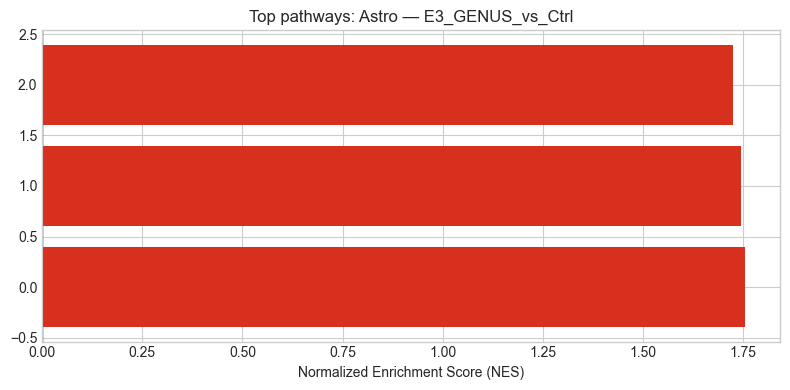

In [22]:
plot_top_pathways(gsea_summary, cell_type="Astro", contrast="E3_GENUS_vs_Ctrl", max_terms=15)
